In [91]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

import io
import pyarrow.parquet as pq
import pickle

from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

from statistics import mean

Objective: Create separate hourly forecast for every bussiest roads

## Load Dataset

In [38]:
PATH_DATA='D:/DSLS/Data Science/data/raw/'
filename_store='/preprocessed_dataset.pkl'
filename_valid='/validation_dataset.pkl'
filename_rec = '/recurring_dataset.pkl'

with open(PATH_DATA+filename_store, 'rb') as f:
  df = pickle.load(f)

with open(PATH_DATA+filename_valid, 'rb') as f:
  df_val = pickle.load(f)

with open(PATH_DATA+filename_rec, 'rb') as f:
  df_rec = pickle.load(f)

Data Structure:
<br>
DF <br>
| <br>
| <br>
+------ ROAD_NAME: str <br>
|.           | <br>
|.           | <br>
|.           +------- WEEKDAYS: int <br>
| <br>
| <br>
| <br>

In [129]:
streets = ['Abdul Wahab',
         'Abdurrahman',
         'Anggrek',
         'Arah Tol Lkr Luar/TMII/Cawang',
         'Arif Rahman Hakim']

In [130]:
df['Bungur Raya'][0].head()

,time_on_day,median_delay,median_length,median_speed_kmh
0,5,98.625000,341.750000,8.035000
1,6,254.761905,549.476190,7.593810
2,7,296.640000,550.040000,7.278600
3,8,228.456522,551.347826,8.198913
4,9,205.875000,501.250000,7.641875


## Modeling Prototype

Objective: Analyze performance of ML model to forecast sampled data

In [132]:
# Sampling
samples=list()
samples.append(df['Bungur Raya'][2])
samples.append(df['Arif Rahman Hakim'][1])
samples.append(df['Anggrek'][3])
samples.append(df['Abdurrahman'][3])
samples.append(df['Abdurrahman'][6])
samples.append(df['Anggrek'][4])

samples_rec = list()
samples_rec.append(df_rec['Bungur Raya'][2])
samples_rec.append(df_rec['Arif Rahman Hakim'][1])
samples_rec.append(df_rec['Anggrek'][3])
samples_rec.append(df_rec['Abdurrahman'][3])
samples_rec.append(df_rec['Abdurrahman'][6])
samples_rec.append(df_rec['Anggrek'][4])


### Splitting

In [133]:
def split_train_test(data):
    train_data = data[:int(0.9*(len(data)))]
    test_data = data[int(0.9*(len(data))):]
    
    print(f"shape of train: {train_data.shape}")
    print(f"shape of test: {test_data.shape}")
    
    return train_data, test_data

In [134]:
train, test = split_train_test(samples[0])

shape of train: (16, 4)
shape of test: (2, 4)


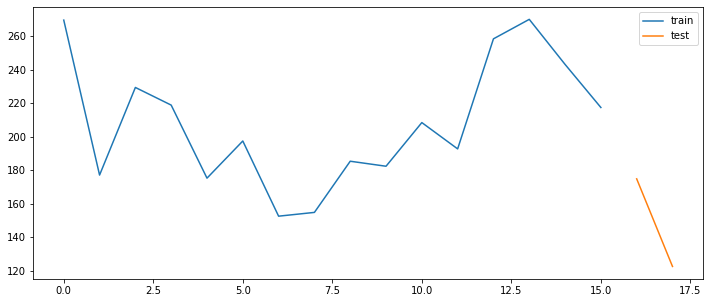

In [135]:
fig, ax=plt.subplots(figsize=(12, 5))
train['median_delay'].plot(ax=ax, label='train')
test['median_delay'].plot(ax=ax, label='test')
ax.legend();
plt.show()

In [136]:
train_r, test_r = split_train_test(samples_rec[0])

shape of train: (276, 15)
shape of test: (31, 15)


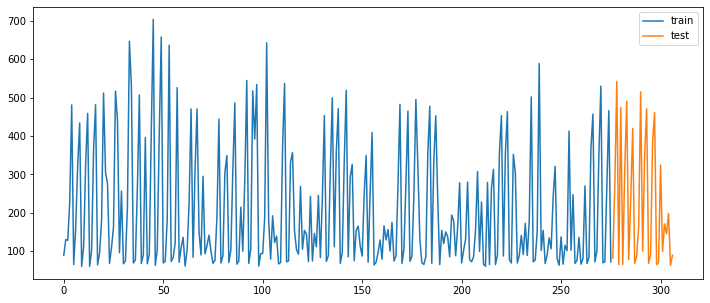

In [137]:
fig, ax=plt.subplots(figsize=(12, 5))
train_r['median_delay'].plot(ax=ax, label='train')
test_r['median_delay'].plot(ax=ax, label='test')
ax.legend();
plt.show()

### Autoregressive Moving Average (ARMA) --> 48.1%

Objective: Forecast model for median_delay

### Daily

In [138]:
# change value here
metric = 'median_delay'

train, test = split_train_test(samples[0])

data_train= train[metric]
data_test= test[metric]

print(f"Train hours : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test hours  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

shape of train: (16, 4)
shape of test: (2, 4)
Train hours : 0 --- 15  (n=16)
Test hours  : 16 --- 17  (n=2)


In [139]:
y = data_train
ARMAmodel = SARIMAX(y, order = (1, 0, 1))
ARMAmodel = ARMAmodel.fit()

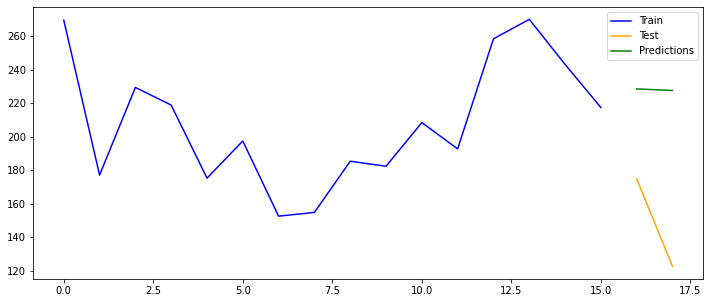

In [140]:
y_pred = ARMAmodel.get_forecast(len(data_test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = data_test.index
y_pred_out = y_pred_df["Predictions"] 

plt.figure(figsize=(12, 5))
plt.plot(data_train, color='blue', label = 'Train')
plt.plot(data_test, color='orange', label = 'Test')
plt.plot(y_pred_out, color='green', label = 'Predictions')
plt.legend()
plt.show()

### Unsplitted

In [141]:
# change value here
metric = 'median_delay'

train_r, test_r = split_train_test(samples_rec[0])

data_train= train_r[metric]
data_test= test_r[metric]

print(f"Train hours : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test hours  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

shape of train: (276, 15)
shape of test: (31, 15)
Train hours : 0 --- 275  (n=276)
Test hours  : 276 --- 306  (n=31)


In [142]:
y = data_train
ARMAmodel = SARIMAX(y, order = (1, 0, 1))
ARMAmodel = ARMAmodel.fit()

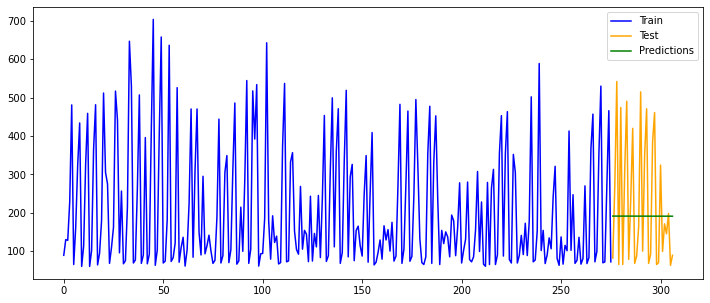

In [143]:
y_pred = ARMAmodel.get_forecast(len(data_test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = data_test.index
y_pred_out = y_pred_df["Predictions"] 

plt.figure(figsize=(12, 5))
plt.plot(data_train, color='blue', label = 'Train')
plt.plot(data_test, color='orange', label = 'Test')
plt.plot(y_pred_out, color='green', label = 'Predictions')
plt.legend()
plt.show()

In [144]:
arma_mape = mean_absolute_percentage_error(data_test.values, y_pred_df["Predictions"])
print(arma_mape)

0.9125156584054788


In [145]:
def black_box_arma():
    mape =  list()
    
    for sample in samples_rec:
        # splitting
        train, test = split_train_test(sample)

        data_train=train['median_delay']
        data_test=test['median_delay']
        
        # modeling 
        y = data_train
        ARMAmodel = SARIMAX(y, order = (1, 0, 1))
        ARMAmodel = ARMAmodel.fit()
        
        # predict
        y_pred = ARMAmodel.get_forecast(len(data_test.index))
        y_pred_df = y_pred.conf_int(alpha = 0.1) 
        y_pred_df["Predictions"] = ARMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
        y_pred_df.index = data_test.index
        y_pred_out = y_pred_df["Predictions"] 
        
        #plot
        plt.figure(figsize=(12, 5))
        plt.plot(data_train, color='blue', label = 'Train')
        plt.plot(data_test, color='orange', label = 'Test')
        plt.plot(y_pred_out, color='green', label = 'Predictions')
        plt.legend()
        plt.show()
        
        mape.append(mean_absolute_percentage_error(data_test.values, y_pred_df["Predictions"]))
        
    return mape

shape of train: (276, 15)
shape of test: (31, 15)


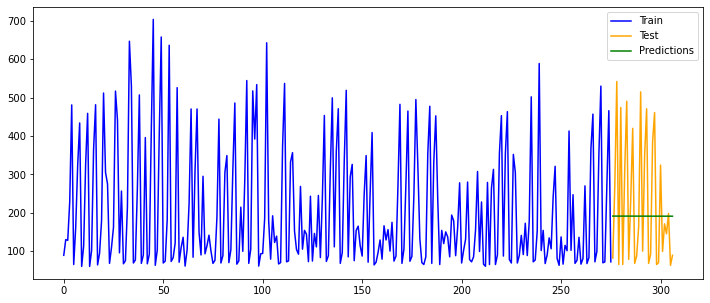

shape of train: (177, 15)
shape of test: (20, 15)


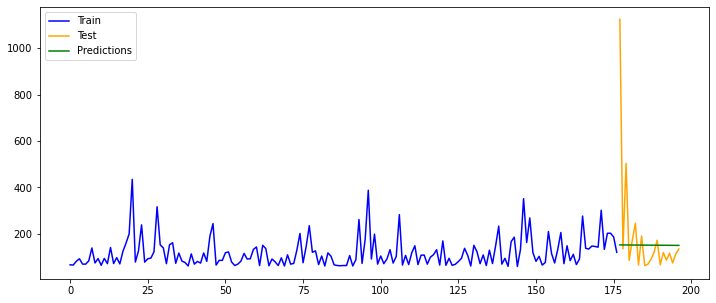

shape of train: (27, 15)
shape of test: (3, 15)


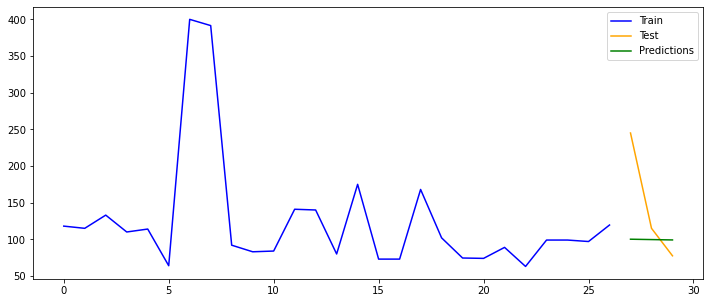

shape of train: (15, 15)
shape of test: (2, 15)


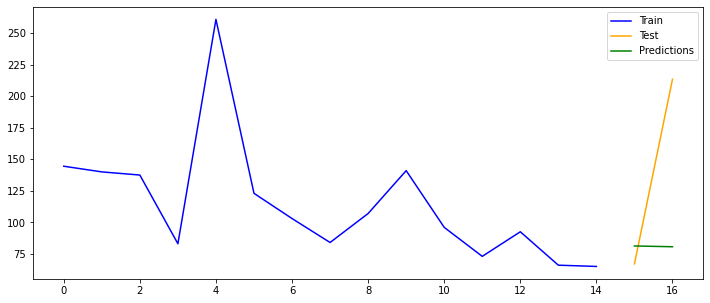

shape of train: (8, 15)
shape of test: (1, 15)


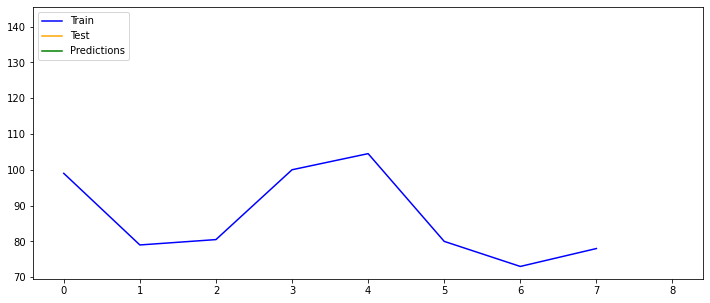

shape of train: (17, 15)
shape of test: (2, 15)


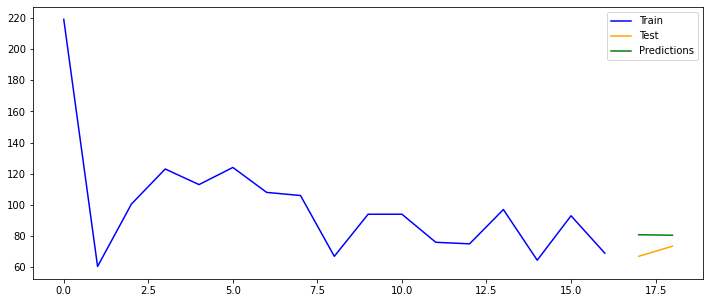

In [146]:
mape = black_box_arma()

In [147]:
mean(mape)

0.4816078732961035

### Autoregressive Integrated Moving Average (ARIMA) --> 42.7%

In [148]:
# change value here
metric = 'median_delay'

train_r, test_r = split_train_test(samples_rec[0])

data_train= train_r[metric]
data_test= test_r[metric]

print(f"Train hours : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test hours  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

shape of train: (276, 15)
shape of test: (31, 15)
Train hours : 0 --- 275  (n=276)
Test hours  : 276 --- 306  (n=31)


In [149]:
y=data_train

ARIMAmodel = ARIMA(y, order = (2, 2, 2))
ARIMAmodel = ARIMAmodel.fit()


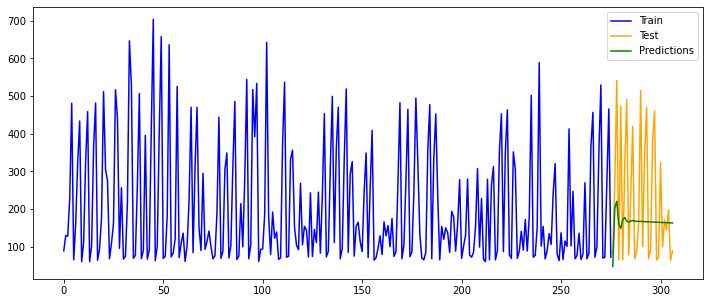

In [150]:
y_pred = ARIMAmodel.get_forecast(len(data_test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = data_test.index
y_pred_out = y_pred_df["Predictions"] 

plt.figure(figsize=(12, 5))
plt.plot(data_train, color='blue', label = 'Train')
plt.plot(data_test, color='orange', label = 'Test')
plt.plot(y_pred_out, color='green', label = 'Predictions')
plt.legend()
plt.show()


In [151]:
mape=mean_absolute_percentage_error(data_test.values, y_pred_df["Predictions"])

print("MAPE: ",mape)

MAPE:  0.7519252316233278


In [152]:
def black_box_arima():
    mape =  list()
    
    for sample in samples_rec:
        # splitting
        train, test = split_train_test(sample)

        data_train=train['median_delay']
        data_test=test['median_delay']
        
        # modeling 
        y = data_train
        ARIMAmodel = ARIMA(y, order = (2, 2, 2))
        ARIMAmodel = ARIMAmodel.fit()
        
        # predict
        y_pred = ARIMAmodel.get_forecast(len(data_test.index))
        y_pred_df = y_pred.conf_int(alpha = 0.1) 
        y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
        y_pred_df.index = data_test.index
        y_pred_out = y_pred_df["Predictions"] 
        
        #plot
        plt.figure(figsize=(12, 5))
        plt.plot(data_train, color='blue', label = 'Train')
        plt.plot(data_test, color='orange', label = 'Test')
        plt.plot(y_pred_out, color='green', label = 'Predictions')
        plt.legend()
        plt.show()
        
        mape.append(mean_absolute_percentage_error(data_test.values, y_pred_df["Predictions"]))
        
    return mape

shape of train: (276, 15)
shape of test: (31, 15)


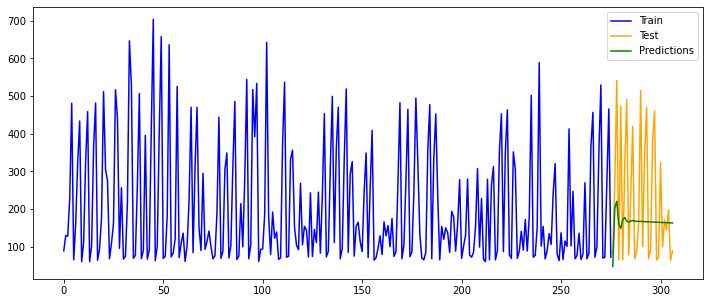

shape of train: (177, 15)
shape of test: (20, 15)


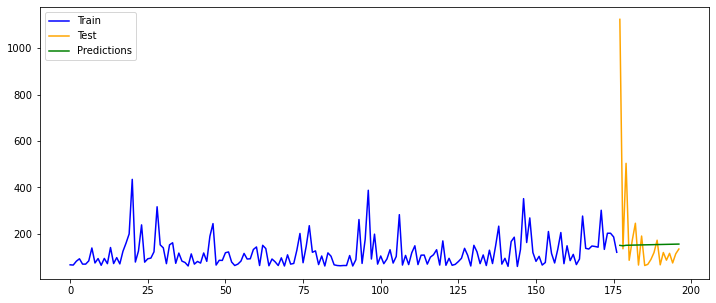

shape of train: (27, 15)
shape of test: (3, 15)


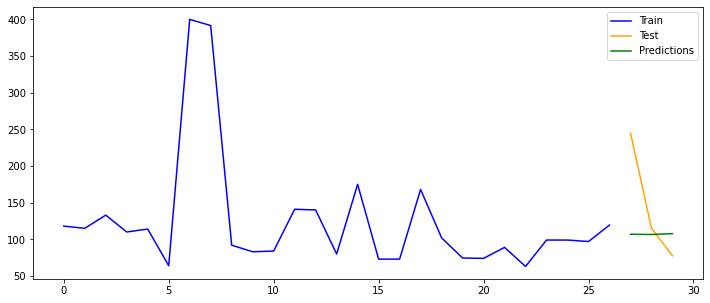

shape of train: (15, 15)
shape of test: (2, 15)


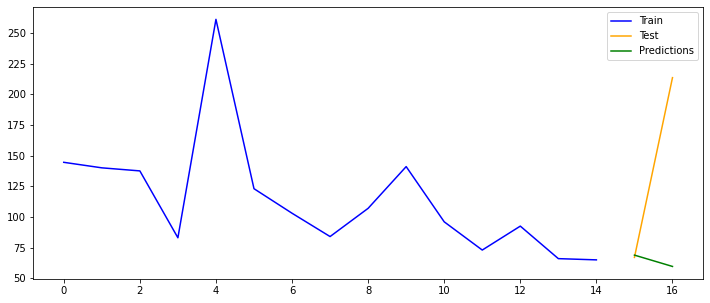

shape of train: (8, 15)
shape of test: (1, 15)


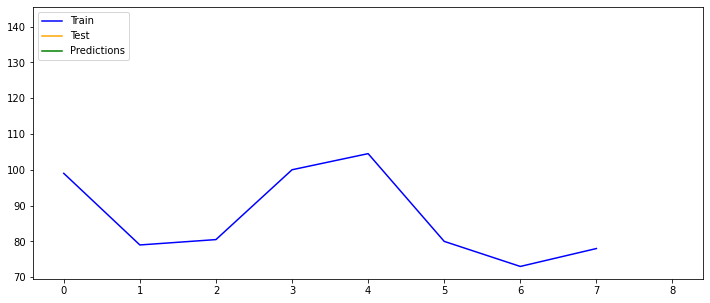

shape of train: (17, 15)
shape of test: (2, 15)


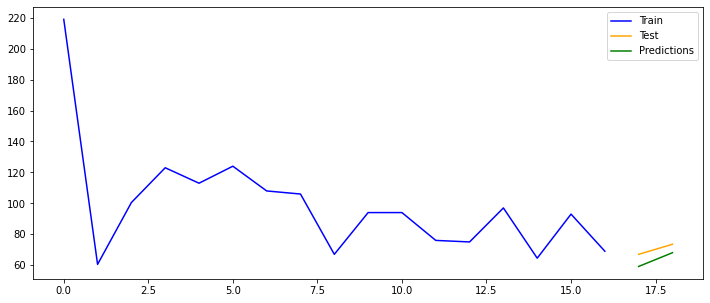

In [153]:
mape = black_box_arima()

In [154]:
mean(mape)

0.42697505782938455

### Seasonal ARIMA (SARIMA) --> 48.9%

In [156]:
sarimamodel = SARIMAX(y, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))
sarimamodel = sarimamodel.fit()

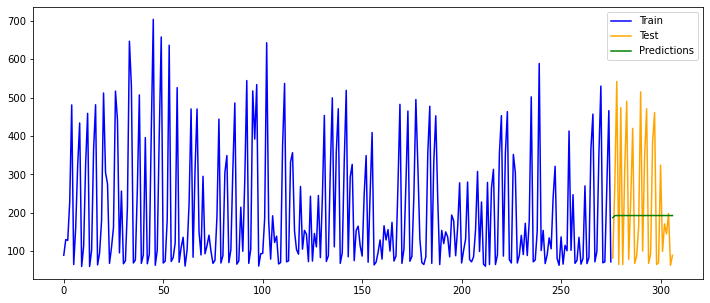

In [164]:
y_pred = sarimamodel.get_forecast(len(data_test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = sarimamodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = data_test.index
y_pred_out = y_pred_df["Predictions"] 

plt.figure(figsize=(12, 5))
plt.plot(data_train, color='blue', label = 'Train')
plt.plot(data_test, color='orange', label = 'Test')
plt.plot(y_pred_out, color='green', label = 'Predictions')
plt.legend()
plt.show()


In [165]:
mape=mean_absolute_percentage_error(data_test.values, y_pred_df["Predictions"])

print("MAPE: ",mape)

MAPE:  0.9186188566308439


In [166]:
def black_box_sarima():
    mape =  list()
    
    for sample in samples_rec:
        # splitting
        train, test = split_train_test(sample)

        data_train=train['median_delay']
        data_test=test['median_delay']
        
        # modeling 
        y = data_train
        sarimamodel = SARIMAX(y, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))
        sarimamodel = sarimamodel.fit()
        
        # predict
        y_pred = sarimamodel.get_forecast(len(data_test.index))
        y_pred_df = y_pred.conf_int(alpha = 0.1) 
        y_pred_df["Predictions"] = sarimamodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
        y_pred_df.index = data_test.index
        y_pred_out = y_pred_df["Predictions"] 
        
        #plot
        plt.figure(figsize=(12, 5))
        plt.plot(data_train, color='blue', label = 'Train')
        plt.plot(data_test, color='orange', label = 'Test')
        plt.plot(y_pred_out, color='green', label = 'Predictions')
        plt.legend()
        plt.show()
        
        mape.append(mean_absolute_percentage_error(data_test.values, y_pred_df["Predictions"]))
        
    return mape

shape of train: (276, 15)
shape of test: (31, 15)


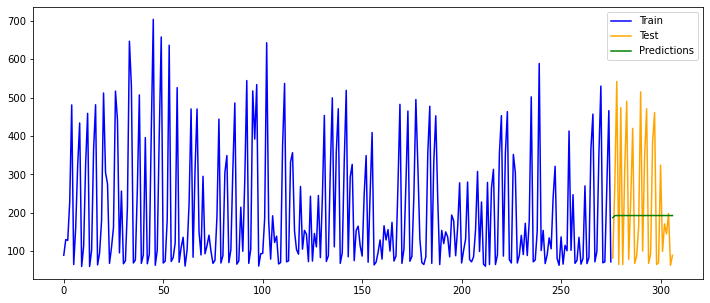

shape of train: (177, 15)
shape of test: (20, 15)


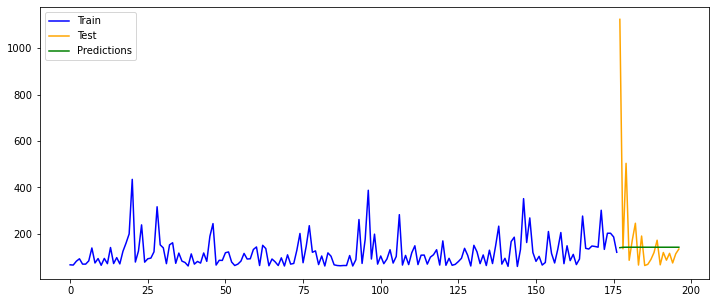

shape of train: (27, 15)
shape of test: (3, 15)


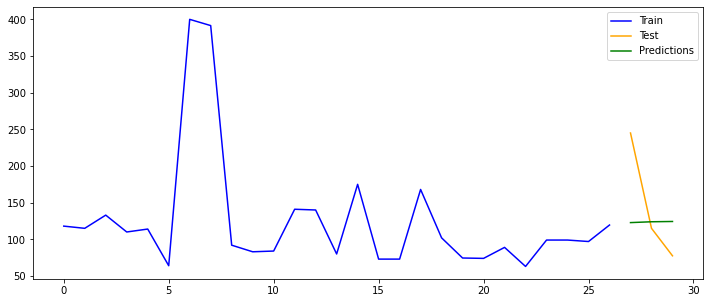

shape of train: (15, 15)
shape of test: (2, 15)


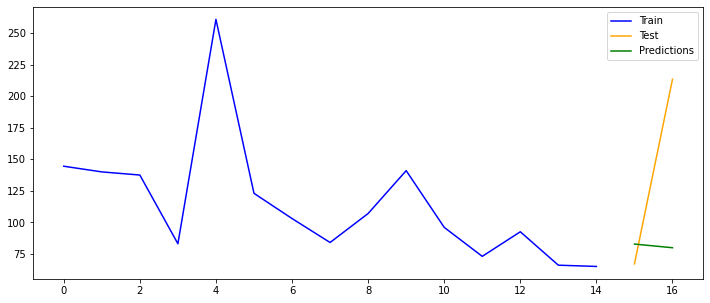

shape of train: (8, 15)
shape of test: (1, 15)


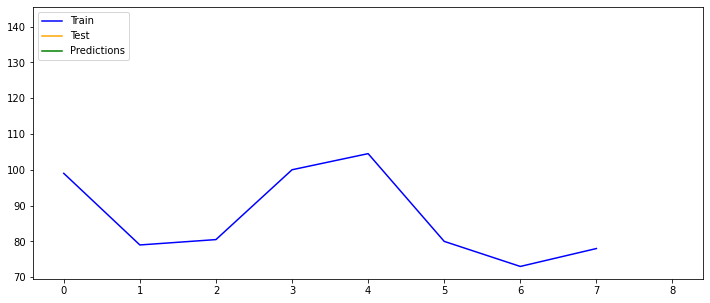

shape of train: (17, 15)
shape of test: (2, 15)


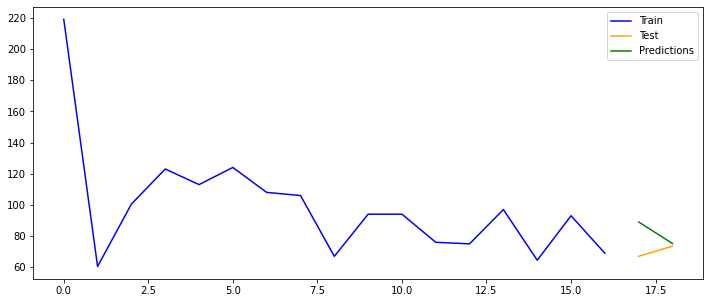

In [167]:
mape = black_box_sarima()

In [168]:
mean(mape)

0.48928809595173833

### Conclusion 

berdasarkan metric MAPE, maka model yang digunakan adalah model ARIMA